# Model Comparison

In [1]:
import json
import sys

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Add src to path
sys.path.insert(0, '../src')

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Imports successful!")

✓ Imports successful!


## Load Test Data

In [2]:
# Load test samples
with open('../data/test_samples.json', 'r') as f:
    test_data = json.load(f)

print(f"Loaded {len(test_data)} test samples")
print("\nExample test case:")
print(f"Text: {test_data[0]['text']}")
print(f"Expected: {test_data[0]['expected']}")

Loaded 25 test samples

Example test case:
Text: The pizza was very delicious but the service was terrible.
Expected: [{'aspect': 'pizza', 'sentiment': 'positive'}, {'aspect': 'service', 'sentiment': 'negative'}]


## Initialize Analyzers

In [3]:
from src.transformer_absa import TransformerABSA
from src.lexicon_absa import LexiconABSA

print("Initializing analyzers...")
lexicon_analyzer = LexiconABSA()
transformer_analyzer = TransformerABSA()

print("✓ Both analyzers ready!")

C:\Users\ronom\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Initializing analyzers...
Loading model: yangheng/deberta-v3-base-absa-v1.1 (device: CPU)


C:\Users\ronom\AppData\Roaming\Python\Python313\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Device set to use cpu


✓ Both analyzers ready!


## Test Single Example

In [4]:
# Test on a single example
test_case = test_data[0]
text = test_case['text']
expected_aspects = [e['aspect'] for e in test_case['expected']]

print(f"Text: '{text}'")
print(f"\nExpected aspects: {expected_aspects}")

# --- Lexicon-Based ---
print("\n" + "=" * 60)
print("LEXICON-BASED RESULTS:")
print("=" * 60)
lexicon_results = lexicon_analyzer.analyze(text)
for r in lexicon_results:
    print(f"  {r.aspect:15} → {r.sentiment:10} (confidence: {r.confidence:.3f})")

# --- Transformer-Based ---
print("\n" + "=" * 60)
print("TRANSFORMER-BASED RESULTS:")
print("=" * 60)
transformer_results = transformer_analyzer.analyze(text, aspects=expected_aspects)
for r in transformer_results:
    print(f"  {r.aspect:15} → {r.sentiment:10} (confidence: {r.confidence:.3f})")

# --- Expected ---
print("\n" + "=" * 60)
print("EXPECTED RESULTS:")
print("=" * 60)
for e in test_case['expected']:
    print(f"  {e['aspect']:15} → {e['sentiment']}")

Text: 'The pizza was very delicious but the service was terrible.'

Expected aspects: ['pizza', 'service']

LEXICON-BASED RESULTS:
Processed text: The pizza was very delicious but the service was terrible.
Noun phrases: [pizza, service]

--- Aspect: 'pizza' ---
  Related verbs:      ['was']
  Nearby adverbs:     ['very']
  Related adjectives: ['delicious']
  Intensifier found near 'delicious': very (+20%)

--- Aspect: 'service' ---
  Related verbs:      ['was']
  Nearby adverbs:     []
  Related adjectives: ['terrible']
  pizza           → positive   (confidence: 0.686)
  service         → negative   (confidence: 0.477)

TRANSFORMER-BASED RESULTS:
  pizza           → positive   (confidence: 0.997)
  service         → negative   (confidence: 0.994)

EXPECTED RESULTS:
  pizza           → positive
  service         → negative


## Run Full Comparison

In [5]:
def evaluate_results(predictions, expected):
    """Calculate accuracy metrics"""
    pred_dict = {p.aspect.lower(): p.sentiment.lower() for p in predictions}
    exp_dict = {e['aspect'].lower(): e['sentiment'].lower() for e in expected}

    correct_aspects = sum(1 for asp in exp_dict if asp in pred_dict)
    correct_sentiments = sum(1 for asp, sent in exp_dict.items()
                             if asp in pred_dict and pred_dict[asp] == sent)

    return {
        'total_expected': len(expected),
        'total_predicted': len(predictions),
        'correct_aspects': correct_aspects,
        'correct_sentiments': correct_sentiments
    }


# Run on all samples
lexicon_metrics = {'correct_aspects': 0, 'correct_sentiments': 0,
                   'total_expected': 0, 'total_predicted': 0}
transformer_metrics = {'correct_aspects': 0, 'correct_sentiments': 0,
                       'total_expected': 0, 'total_predicted': 0}

results_list = []

for i, test_case in enumerate(test_data):
    text = test_case['text']
    expected = test_case['expected']
    expected_aspects = [e['aspect'] for e in expected]

    # Get predictions
    lex_results = lexicon_analyzer.analyze(text)
    trans_results = transformer_analyzer.analyze(text, expected_aspects)

    # Evaluate
    lex_eval = evaluate_results(lex_results, expected)
    trans_eval = evaluate_results(trans_results, expected)

    # Store results
    results_list.append({
        'text': text,
        'lexicon_correct': lex_eval['correct_sentiments'],
        'transformer_correct': trans_eval['correct_sentiments'],
        'total_aspects': len(expected)
    })

    # Aggregate
    for key in ['correct_aspects', 'correct_sentiments', 'total_expected', 'total_predicted']:
        lexicon_metrics[key] += lex_eval[key]
        transformer_metrics[key] += trans_eval[key]

    if (i + 1) % 5 == 0:
        print(f"Processed {i + 1}/{len(test_data)} samples...")

print("\n✓ Evaluation complete!")

Processed text: The pizza was very delicious but the service was terrible.
Noun phrases: [pizza, service]

--- Aspect: 'pizza' ---
  Related verbs:      ['was']
  Nearby adverbs:     ['very']
  Related adjectives: ['delicious']
  Intensifier found near 'delicious': very (+20%)

--- Aspect: 'service' ---
  Related verbs:      ['was']
  Nearby adverbs:     []
  Related adjectives: ['terrible']
Processed text: The food was not good  sad .
Noun phrases: [food]

--- Aspect: 'food' ---
  Related verbs:      ['was']
  Nearby adverbs:     []
  Related adjectives: ['sad']
Processed text: The service isn't bad.
Noun phrases: [service]

--- Aspect: 'service' ---
  Related verbs:      ['is']
  Nearby adverbs:     []
  Related adjectives: ['bad']
  Negation affecting 'bad': ["n't"]
Processed text: The room was okay but the bathroom was dirty.
Noun phrases: [room, bathroom]

--- Aspect: 'room' ---
  Related verbs:      ['was']
  Nearby adverbs:     []
  Related adjectives: ['okay']

--- Aspect: 'bat

## Display Summary Statistics

In [6]:
# Calculate percentages
lex_aspect_acc = lexicon_metrics['correct_aspects'] / lexicon_metrics['total_expected'] * 100
lex_sent_acc = lexicon_metrics['correct_sentiments'] / lexicon_metrics['total_expected'] * 100

trans_aspect_acc = transformer_metrics['correct_aspects'] / transformer_metrics['total_expected'] * 100
trans_sent_acc = transformer_metrics['correct_sentiments'] / transformer_metrics['total_expected'] * 100

# Create summary DataFrame
summary_data = {
    'Implementation': ['Lexicon-Based', 'Transformer-Based'],
    'Aspect Accuracy (%)': [lex_aspect_acc, trans_aspect_acc],
    'Sentiment Accuracy (%)': [lex_sent_acc, trans_sent_acc],
    'Total Predictions': [lexicon_metrics['total_predicted'],
                          transformer_metrics['total_predicted']],
    'Correct Sentiments': [lexicon_metrics['correct_sentiments'],
                           transformer_metrics['correct_sentiments']]
}

summary_df = pd.DataFrame(summary_data)
print("\nSUMMARY STATISTICS")
print("=" * 80)
print(summary_df.to_string(index=False))


SUMMARY STATISTICS
   Implementation  Aspect Accuracy (%)  Sentiment Accuracy (%)  Total Predictions  Correct Sentiments
    Lexicon-Based            53.191489               31.914894                 36                  15
Transformer-Based           100.000000               82.978723                 47                  39


## Visualize Results - Bar Chart

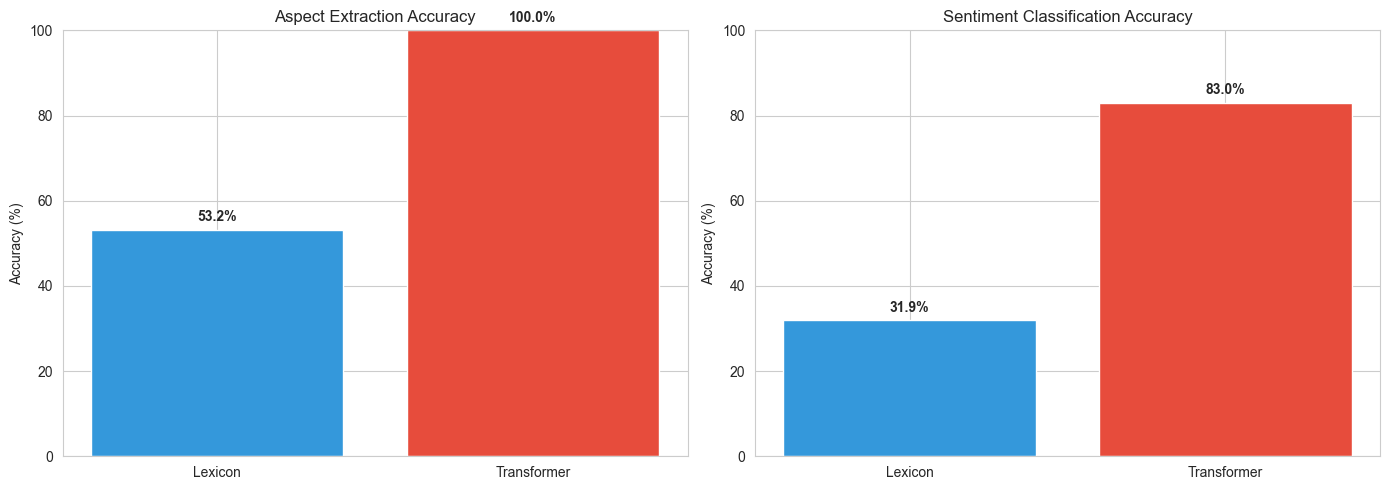

In [7]:
# Create comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Aspect Accuracy
aspects_data = ['Lexicon', 'Transformer']
aspects_values = [lex_aspect_acc, trans_aspect_acc]
axes[0].bar(aspects_data, aspects_values, color=['#3498db', '#e74c3c'])
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Aspect Extraction Accuracy')
axes[0].set_ylim([0, 100])
for i, v in enumerate(aspects_values):
    axes[0].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Sentiment Accuracy
sentiment_data = ['Lexicon', 'Transformer']
sentiment_values = [lex_sent_acc, trans_sent_acc]
axes[1].bar(sentiment_data, sentiment_values, color=['#3498db', '#e74c3c'])
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Sentiment Classification Accuracy')
axes[1].set_ylim([0, 100])
for i, v in enumerate(sentiment_values):
    axes[1].text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

## Per-Sample Comparison


PER-SAMPLE RESULTS (First 10 samples)


,text,lexicon_correct,transformer_correct,total_aspects,lexicon_accuracy,transformer_accuracy
0,The pizza was very delicious but the service w...,2,2,2,100.000000,100.0
1,The food was not good :(.,1,1,1,100.000000,100.0
2,The service isn't bad.,1,1,1,100.000000,100.0
3,The room was okay but the bathroom was dirty.,2,1,2,100.000000,50.0
4,The phone has great battery life but the camer...,0,2,2,0.000000,100.0
5,The laptop runs fast but the fan is so loud th...,0,2,2,0.000000,100.0
6,"The movie was long and boring, but the soundtr...",1,2,2,50.000000,100.0
7,"The coffee was too hot to drink, but it tasted...",0,0,1,0.000000,0.0
8,"The restaurant decor is nice, but the food is ...",1,3,3,33.333333,100.0
9,"The service was absolutely outstanding, and th...",1,2,2,50.000000,100.0


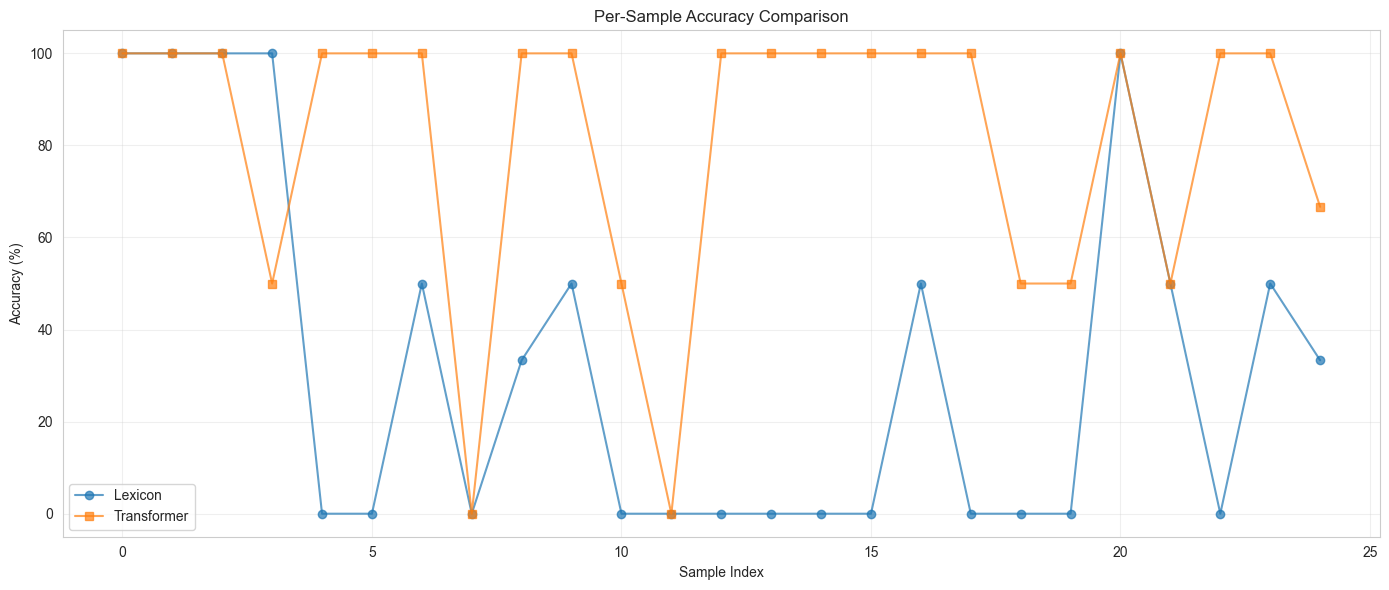

In [8]:
# Create DataFrame for detailed comparison
results_df = pd.DataFrame(results_list)
results_df['lexicon_accuracy'] = results_df['lexicon_correct'] / results_df['total_aspects'] * 100
results_df['transformer_accuracy'] = results_df['transformer_correct'] / results_df['total_aspects'] * 100

print("\nPER-SAMPLE RESULTS (First 10 samples)")
print("=" * 80)
display(results_df.head(10))

# Plot per-sample comparison
plt.figure(figsize=(14, 6))
x = range(len(results_df))
plt.plot(x, results_df['lexicon_accuracy'], label='Lexicon', marker='o', alpha=0.7)
plt.plot(x, results_df['transformer_accuracy'], label='Transformer', marker='s', alpha=0.7)
plt.xlabel('Sample Index')
plt.ylabel('Accuracy (%)')
plt.title('Per-Sample Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Identify Challenging Cases

In [9]:
# Find cases where both models struggled
challenging_cases = results_df[
    (results_df['lexicon_accuracy'] < 100) &
    (results_df['transformer_accuracy'] < 100)
    ]

print(f"\nChallenging Cases (both models < 100%): {len(challenging_cases)}")
print("=" * 80)

for idx in challenging_cases.index[:5]:  # Show first 5
    print(f"\nSample {idx}:")
    print(f"Text: {test_data[idx]['text']}")
    print(f"Lexicon accuracy: {results_df.loc[idx, 'lexicon_accuracy']:.1f}%")
    print(f"Transformer accuracy: {results_df.loc[idx, 'transformer_accuracy']:.1f}%")
    print(f"Expected: {test_data[idx]['expected']}")


Challenging Cases (both models < 100%): 7

Sample 7:
Text: The coffee was too hot to drink, but it tasted amazing once it cooled down.
Lexicon accuracy: 0.0%
Transformer accuracy: 0.0%
Expected: [{'aspect': 'coffee', 'sentiment': 'positive'}]

Sample 10:
Text: I waited an hour for my food, but at least it was cold when it finally arrived.
Lexicon accuracy: 0.0%
Transformer accuracy: 50.0%
Expected: [{'aspect': 'food', 'sentiment': 'negative'}, {'aspect': 'service', 'sentiment': 'negative'}]

Sample 11:
Text: The book was not terrible, but it wasnâ€™t great either.
Lexicon accuracy: 0.0%
Transformer accuracy: 0.0%
Expected: [{'aspect': 'book', 'sentiment': 'neutral'}]

Sample 18:
Text: I love how the app looks, but it crashes every single time I open it.
Lexicon accuracy: 0.0%
Transformer accuracy: 50.0%
Expected: [{'aspect': 'design', 'sentiment': 'positive'}, {'aspect': 'app', 'sentiment': 'negative'}]

Sample 19:
Text: The pizza was so burnt I could use it as a frisbee. Great job, c

## Strengths Analysis

Lexicon better: 1 cases (4.0%)
Transformer better: 17 cases (68.0%)
Equal performance: 7 cases


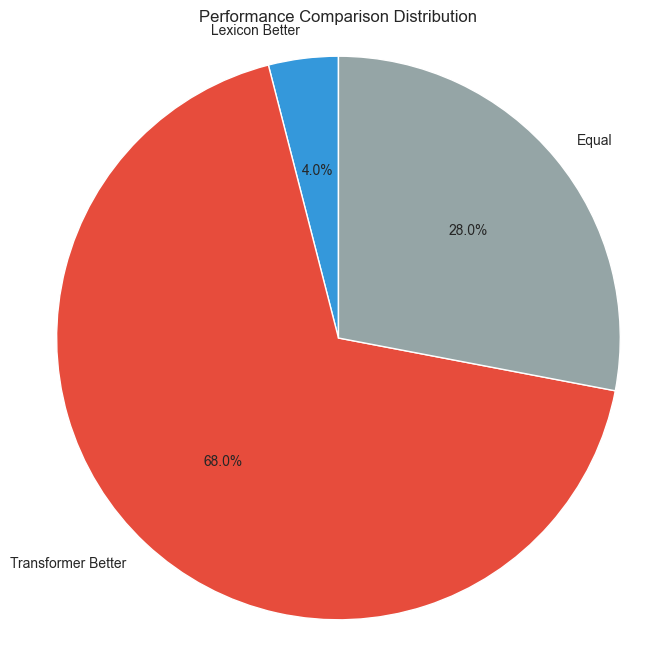

In [10]:
# Cases where lexicon outperforms
lexicon_better = results_df[
    results_df['lexicon_accuracy'] > results_df['transformer_accuracy']
    ]

# Cases where transformer outperforms
transformer_better = results_df[
    results_df['transformer_accuracy'] > results_df['lexicon_accuracy']
    ]

print(f"Lexicon better: {len(lexicon_better)} cases ({len(lexicon_better) / len(results_df) * 100:.1f}%)")
print(f"Transformer better: {len(transformer_better)} cases ({len(transformer_better) / len(results_df) * 100:.1f}%)")
print(f"Equal performance: {len(results_df) - len(lexicon_better) - len(transformer_better)} cases")

# Visualize
labels = ['Lexicon Better', 'Transformer Better', 'Equal']
sizes = [len(lexicon_better), len(transformer_better),
         len(results_df) - len(lexicon_better) - len(transformer_better)]
colors = ['#3498db', '#e74c3c', '#95a5a6']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Performance Comparison Distribution')
plt.axis('equal')
plt.show()

## Conclusion and Insights

In [11]:
print("KEY INSIGHTS")
print("=" * 80)
print(f"""
1. Overall Performance:
   - Lexicon Sentiment Accuracy: {lex_sent_acc:.2f}%
   - Transformer Sentiment Accuracy: {trans_sent_acc:.2f}%
   - Winner: {'Lexicon' if lex_sent_acc > trans_sent_acc else 'Transformer'}

2. Aspect Extraction:
   - Lexicon found: {lexicon_metrics['total_predicted']} aspects
   - Transformer found: {transformer_metrics['total_predicted']} aspects
   - Expected: {lexicon_metrics['total_expected']} aspects

3. Strengths:
   - Lexicon: {len(lexicon_better)} cases where it outperformed
   - Transformer: {len(transformer_better)} cases where it outperformed

4. Challenging Cases:
   - {len(challenging_cases)} cases where both struggled
""")

KEY INSIGHTS

1. Overall Performance:
   - Lexicon Sentiment Accuracy: 31.91%
   - Transformer Sentiment Accuracy: 82.98%
   - Winner: Transformer

2. Aspect Extraction:
   - Lexicon found: 36 aspects
   - Transformer found: 47 aspects
   - Expected: 47 aspects

3. Strengths:
   - Lexicon: 1 cases where it outperformed
   - Transformer: 17 cases where it outperformed

4. Challenging Cases:
   - 7 cases where both struggled

